In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [2]:
plt.rcParams.update({'font.size': 25})
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
path_to_data_train = Path.cwd() / ".." / "data" / "final" / "images" / "train" / "objects_results.csv"
path_to_data_test = Path.cwd() / ".." / "data" / "final" / "images" / "test" / "objects_results.csv"
path_to_resolution_train = Path.cwd() / ".." / "data" / "final" / "images" / "train" / "nifti_resolution.csv"
path_to_resolution_test = Path.cwd() / ".." / "data" / "final" / "images" / "test" / "nifti_resolution.csv"
path_to_image_stats_train = Path.cwd() / "resources" / "intensity_stats_train.csv"
path_to_image_stats_test = Path.cwd() / "resources" / "intensity_stats_test.csv"
path_to_image_densities_train = Path.cwd() / "resources" / "densities_train.npy"
path_to_image_densities_test = Path.cwd() / "resources" / "densities_test.npy"
path_to_patients = Path.cwd() / ".." / "data" / "final" / "metadata" / "patients.csv"
path_to_series = Path.cwd() / ".." / "data" / "final" / "metadata" / "series.json"
savefig = False
add_title = False
savecsv = False

In [4]:
# Concatenate train and test files
objects_df = pd.DataFrame()
for path, subset_name in [(path_to_data_train, 'train'), (path_to_data_test, 'test')]:
    subset_df = pd.read_csv(path)
    subset_df['subset'] = subset_name
    objects_df = pd.concat(
        [objects_df, subset_df],
        ignore_index=True
    )
objects_df.rename(columns={"label_description_en": "label_description"}, inplace=True)
objects_df['lesion_type'] = objects_df['label_description'].apply(lambda x: x.split(',')[0])
objects_df['lesion_location'] = objects_df['label_description'].apply(lambda x: x.split(',')[1])

In [5]:
# Normalize label descriptions
def normalize_label_description(row):
    return ','.join([value.lower().strip() for value in row['label_description'].split(',')])

objects_df['label_description'] = objects_df.apply(
    lambda row: normalize_label_description(row),
    axis=1
)

In [6]:
# Add patient information
def add_patient_info(objects_df, path_to_patients, path_to_series):
    output_df = objects_df.copy()
    output_df['uuid'] = output_df['filename'].apply(lambda x: x.split('.nii.gz')[0])
    with open(path_to_series, 'r') as file:
        series_df = pd.DataFrame(json.load(file))
    output_df = output_df.merge(
        series_df[['region', 'uuid', 'patient_id', 'study_date', 'study_uuid']],
        on='uuid',
        how='left'
    )
    patients_df = pd.read_csv(path_to_patients)
    # Drop 'subset' to avoid duplication
    patients_df.drop(columns='subset', inplace=True, errors='ignore')
    output_df = output_df.merge(
        patients_df,
        on='patient_id',
        how='left'
    )
    output_df.sort_values(
        by=[
            'filename',
            'study_date',
            'label_value'
        ],
        inplace=True
    )
    return output_df
objects_df = add_patient_info(objects_df, path_to_patients, path_to_series)
objects_df.rename(columns={"region": "series_region"}, inplace=True)
all_objects_df = objects_df.copy()

In [7]:
# Get included series
def get_series_df(path_to_train_csv, path_to_test_csv, path_to_series):
    with open(path_to_series, 'r') as file:
        series_df = pd.DataFrame(json.load(file))
    series_df.drop(
        columns=[
            'rows',
            'columns',
            'slices',
            'row_spacing',
            'column_spacing'
        ],
        inplace=True
    )
    df = pd.DataFrame()
    for subset, path in [('train', path_to_train_csv), ('test', path_to_test_csv)]:
        df = pd.concat([df, pd.read_csv(path)], ignore_index=True)
        df['uuid'] = df['filename'].apply(lambda x: x.split('.nii.gz')[0])
        df['subset'] = subset
    series_df = series_df.merge(
        df,
        on='uuid',
        how='right'
    )
    series_df.rename(columns={"region": "series_region"}, inplace=True)
    return series_df
series_df = get_series_df(path_to_resolution_train, path_to_resolution_test, path_to_series)

In [8]:
# Stats of removed lesions size
print(f"original objects count: {len(all_objects_df)}")
removed_df = all_objects_df[all_objects_df['removed'] == True].copy()
objects_df = all_objects_df[all_objects_df['removed'] == False].copy()
if savecsv:
    objects_df.to_csv(Path.cwd() / 'results' / 'lesions_all.csv', index=False)
print(f"removed objects with volume < 50 voxels: {len(removed_df[removed_df['size_voxels'] < 50])}")
print(f"removed objects with n_slices == 1: {len(removed_df[removed_df['slices_count'] == 1])}")
print(f"total removed objects: {len(removed_df)}")
print(f"final objects count: {len(objects_df)}")
total_lesions_count_final = len(objects_df)
if savecsv:
    objects_df.to_csv(Path.cwd() / 'results' / 'lesions_final.csv', index=False)

original objects count: 1545
removed objects with volume < 50 voxels: 277
removed objects with n_slices == 1: 287
total removed objects: 309
final objects count: 1236


In [9]:
# distribution of patients for each cancer type
grouped = objects_df.groupby(['diagnosis'])['patient_id'].nunique().reset_index(name="patients_count").sort_values(by="patients_count", ascending=False)
total_patients_count = grouped['patients_count'].sum()
display(grouped)

,diagnosis,patients_count
2,colon cancer,5
4,gastric cancer,5
5,lung cancer,4
3,gallbladder cancer,2
8,rectal cancer,2
0,bladder cancer,1
1,breast cancer,1
6,melanoma,1
7,ovarian cancer,1


,patient_id,sex,age,diagnosis,subset,health_insurance
753,10,M,67,melanoma,test,public
0,12,F,56,breast cancer,train,uninsured
756,15,M,64,bladder cancer,test,uninsured
345,22,M,64,colon cancer,train,uninsured
355,24,F,75,gastric cancer,train,uninsured
765,18,M,65,colon cancer,test,uninsured
772,28,F,37,colon cancer,test,uninsured
636,7,M,53,rectal cancer,train,uninsured
642,5,F,59,colon cancer,train,uninsured
1125,13,M,58,gastric cancer,test,uninsured


Age statistics
--------------------


count    22.000000
mean     62.318182
std       8.385852
min      37.000000
25%      58.250000
50%      64.000000
75%      67.750000
max      75.000000
Name: age, dtype: float64

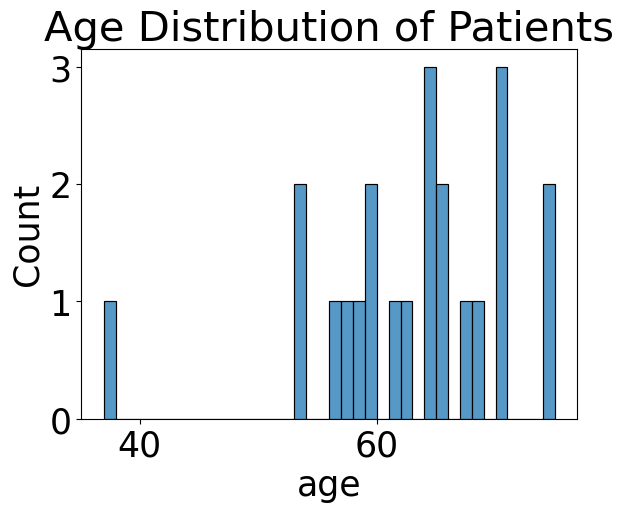

sex
M    11
F    11
Name: count, dtype: int64

subset
train    14
test      8
Name: count, dtype: int64

health_insurance
uninsured    16
public        5
private       1
Name: count, dtype: int64

In [10]:
# Distribution of age, sex and healthcate insurance
patient_columns = ['patient_id', 'sex', 'age', 'diagnosis', 'subset', 'health_insurance']
patients = objects_df.drop_duplicates(subset="patient_id")[patient_columns]
display(patients)
# age
print("Age statistics")
print(20 * '-')
display(patients['age'].describe())
sns.histplot(data=patients, x='age', binwidth=1)
plt.title('Age Distribution of Patients')
plt.show()
# sex
counts = patients['sex'].value_counts()
display(counts)
# Subset
print('\n')
counts = patients['subset'].value_counts()
display(counts)
# Health insurance
print('\n')
counts = patients['health_insurance'].value_counts()
display(counts)

In [11]:
# Studies per patients and total studies
size_grouped = objects_df.groupby(['subset', 'patient_id', 'diagnosis']).size().reset_index(name='lesions_count')
grouped = objects_df.groupby(['subset', 'patient_id', 'diagnosis'])[['study_uuid', 'filename']].nunique().reset_index()
grouped.rename(columns={'study_uuid': 'studies_count', 'filename': 'series_count'}, inplace=True)
grouped = grouped.merge(
    size_grouped,
    on=['subset', 'patient_id', 'diagnosis'],
    how='left',
)
total_studies_count = grouped['studies_count'].sum()
display(grouped)
print(f"total studies: {total_studies_count}")
print(f"min date: {objects_df['study_date'].min()}")
print(f"max date: {objects_df['study_date'].max()}")

,subset,patient_id,diagnosis,studies_count,series_count,lesions_count
0,test,3,gallbladder cancer,3,3,9
1,test,10,melanoma,1,1,3
2,test,13,gastric cancer,3,3,6
3,test,15,bladder cancer,3,3,9
4,test,18,colon cancer,1,1,7
5,test,28,colon cancer,2,4,574
6,test,30,rectal cancer,3,3,39
7,test,35,gastric cancer,2,2,6
8,train,1,lung cancer,1,2,3
9,train,2,gastric cancer,1,2,3


total studies: 48
min date: 20171215
max date: 20231017


In [12]:
# CT images for subset
grouped = objects_df.groupby('subset')['filename'].nunique().reset_index(name="images_count")
display(grouped)

,subset,images_count
0,test,20
1,train,38


In [13]:
# CT images for thorax and abdomen
grouped = objects_df.groupby(['series_region'])['filename'].nunique().reset_index(name="images_count")
total_ct_images_count = grouped["images_count"].sum()
display(grouped)

,series_region,images_count
0,abdomen,36
1,thorax,22


In [14]:
# Lesions grouped by subset
grouped = objects_df.groupby('subset').size().reset_index(name='lesions_count')
display(grouped)

,subset,lesions_count
0,test,653
1,train,583


In [15]:
# Distribution by lesion type (primary, metastases, adenopathy)
grouped = objects_df.groupby('lesion_type').size().reset_index(name='lesions_count')
display(grouped)

,lesion_type,lesions_count
0,m,1138
1,n,93
2,t,5


In [16]:
# Summary
print('Summary')
print(30 * '-')
print(f"patients: {total_patients_count}")
print(f"studies: {total_studies_count}")
print(f"CT images (series): {total_ct_images_count}")
print(f"lesions: {total_lesions_count_final}")

Summary
------------------------------
patients: 22
studies: 48
CT images (series): 58
lesions: 1236


In [17]:
plt.rcParams.update({'font.size': 16}) # 25 for histograms and boxplots, 16 for bars

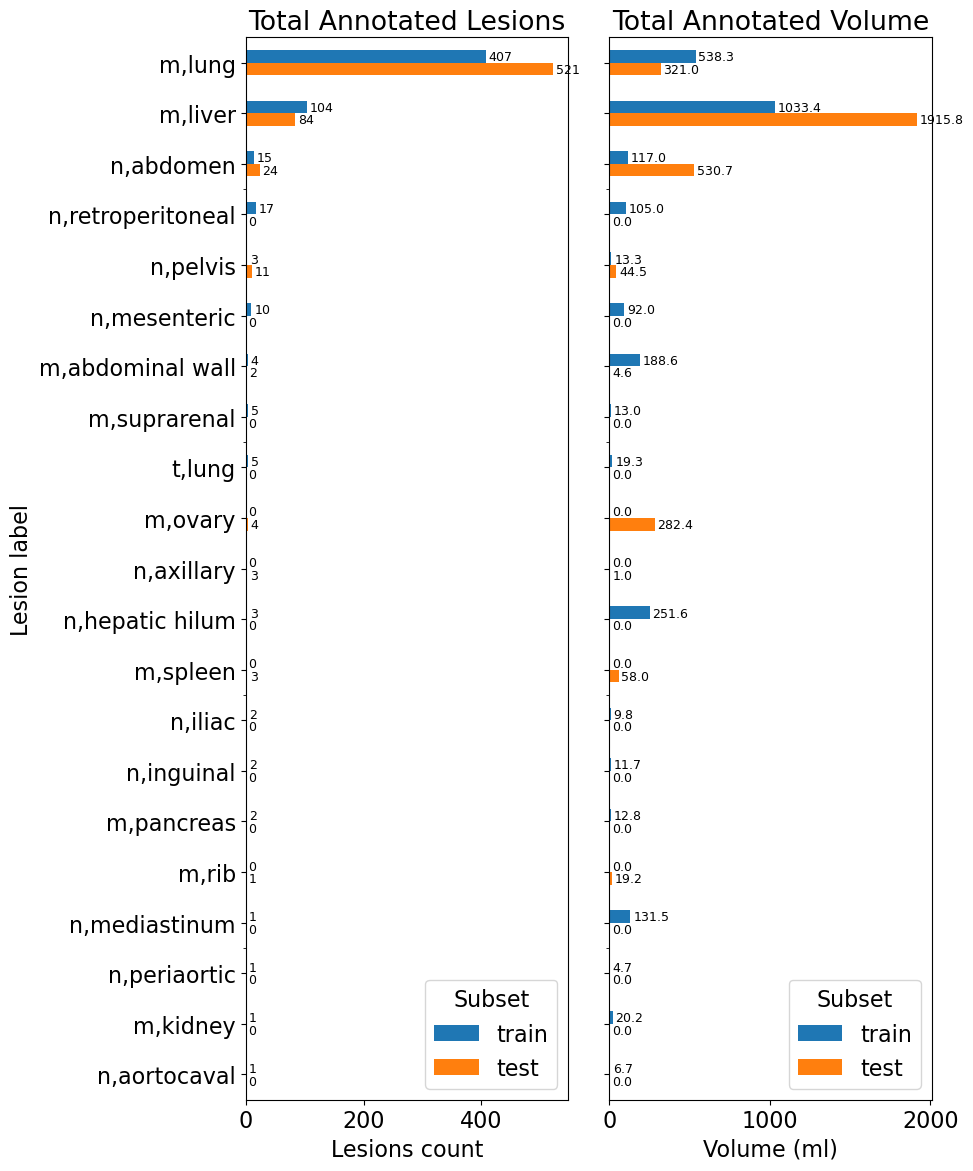

In [18]:
# Horizontal barplots for annotated lesions and annotated volume
_, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 12))
count_grouped = objects_df.groupby(['label_description', 'subset']).size().unstack(fill_value=0)
count_grouped['total'] = count_grouped.sum(axis=1)
count_grouped.sort_values(by='total', inplace=True)
volume_grouped = objects_df.groupby(['label_description', 'subset'])['volume_ml'].sum().unstack(fill_value=0)
volume_grouped['total'] = volume_grouped.sum(axis=1)
for idx, (ax, grouped) in enumerate(zip(axes, [count_grouped, volume_grouped])):
    grouped = grouped.reindex(count_grouped.index)
    grouped[['test', 'train']].plot(
        kind='barh',
        stacked=False,
        color=[plt.cm.tab10.colors[1], plt.cm.tab10.colors[0]],
        ax=ax
    )
    for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds
        text = f'{int(width)}' if idx == 0 else f'{width:.1f}'
        ax.annotate(text, xy=(left + width, bottom + height / 2), xytext=(2.0, -0.25), 
                    textcoords='offset points', ha='left', va='center', fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(list(reversed(handles)), list(reversed(labels)), title='Subset', loc='lower right')
axes[0].set_xlabel('Lesions count')
axes[1].set_xlabel('Volume (ml)')
axes[0].set_title('Total Annotated Lesions')
axes[1].set_title('Total Annotated Volume')
axes[0].set_ylabel('Lesion label')
plt.tight_layout()
if savefig:
    plt.savefig(Path.cwd() / 'results' / 'lesions_count_by_label_and_subset_subplots.png', transparent=True)
plt.show()

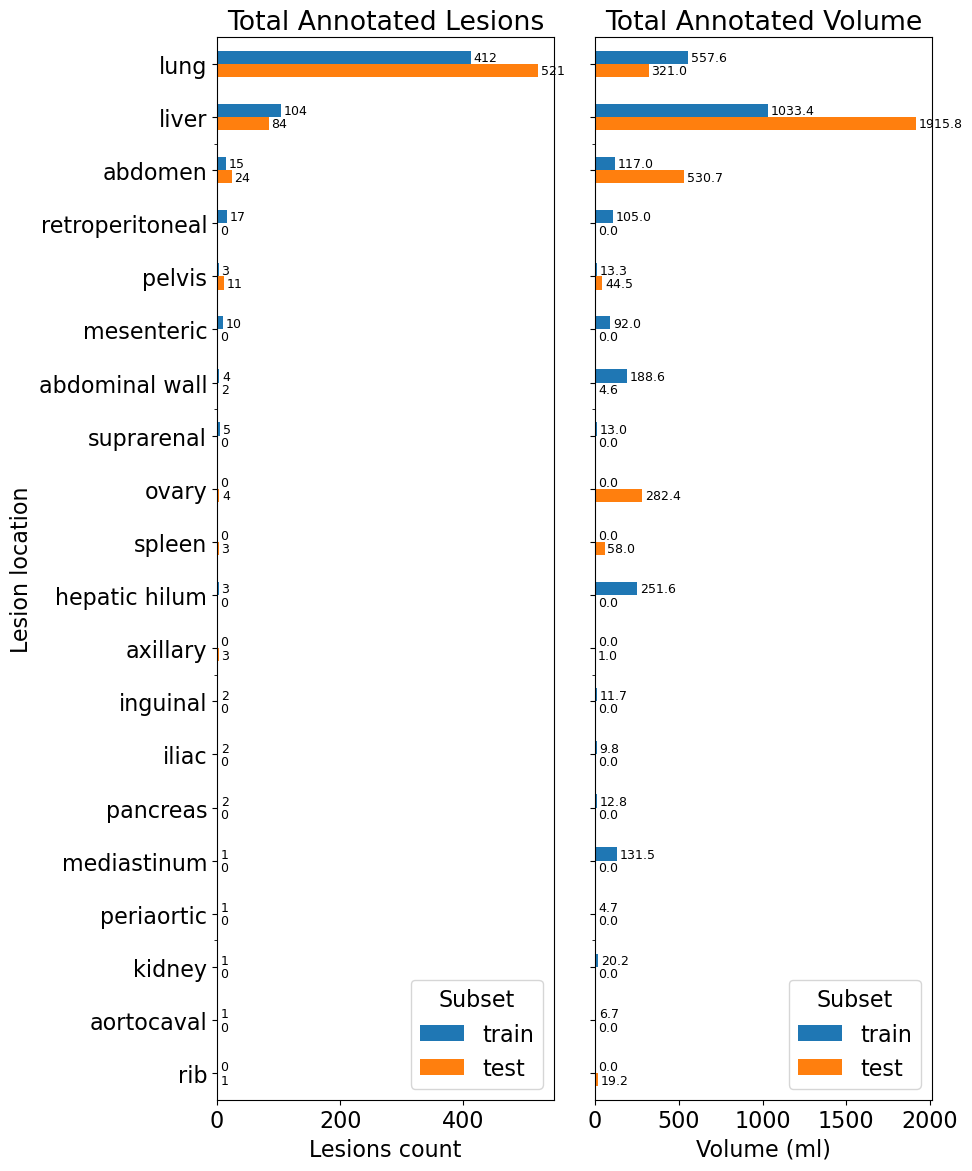

In [19]:
# Horizontal barplots for annotated lesions and annotated volume gruped by lesion location
_, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 12))
count_grouped = objects_df.groupby(['lesion_location', 'subset']).size().unstack(fill_value=0)
count_grouped['total'] = count_grouped.sum(axis=1)
count_grouped.sort_values(by='total', inplace=True)
volume_grouped = objects_df.groupby(['lesion_location', 'subset'])['volume_ml'].sum().unstack(fill_value=0)
volume_grouped['total'] = volume_grouped.sum(axis=1)
for idx, (ax, grouped) in enumerate(zip(axes, [count_grouped, volume_grouped])):
    grouped = grouped.reindex(count_grouped.index)
    grouped[['test', 'train']].plot(
        kind='barh',
        stacked=False,
        color=[plt.cm.tab10.colors[1], plt.cm.tab10.colors[0]],
        ax=ax
    )
    for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds
        text = f'{int(width)}' if idx == 0 else f'{width:.1f}'
        ax.annotate(text, xy=(left + width, bottom + height / 2), xytext=(2.0, -0.25), 
                    textcoords='offset points', ha='left', va='center', fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(list(reversed(handles)), list(reversed(labels)), title='Subset', loc='lower right')
axes[0].set_xlabel('Lesions count')
axes[1].set_xlabel('Volume (ml)')
axes[0].set_title('Total Annotated Lesions')
axes[1].set_title('Total Annotated Volume')
axes[0].set_ylabel('Lesion location')
plt.tight_layout()
if savefig:
    plt.savefig(Path.cwd() / 'results' / 'lesions_count_by_location_and_subset_subplots.svg', transparent=True)
plt.show()

In [20]:
# Lesions count for each CT image
grouped = objects_df.groupby(['subset', 'patient_id', 'diagnosis', 'filename', 'study_date']).size().reset_index(name='lesions_count')
display(grouped)

,subset,patient_id,diagnosis,filename,study_date,lesions_count
0,test,3,gallbladder cancer,1.3.12.2.1107.5.1.4.83504.30000021061509140333600009084.nii.gz,20210615,3
1,test,3,gallbladder cancer,1.3.12.2.1107.5.1.4.83504.30000021082509324422300004131.nii.gz,20210825,3
2,test,3,gallbladder cancer,1.3.12.2.1107.5.1.4.83504.30000021102712332815800004663.nii.gz,20211027,3
3,test,10,melanoma,1.3.12.2.1107.5.1.4.83504.30000017121507082014000029608.nii.gz,20171215,3
4,test,13,gastric cancer,1.3.12.2.1107.5.1.4.83504.30000021061014315422700023041.nii.gz,20210610,2
5,test,13,gastric cancer,1.3.12.2.1107.5.1.4.83504.30000021081905213109000029485.nii.gz,20210819,2
6,test,13,gastric cancer,1.3.12.2.1107.5.1.4.83504.30000021102112360685900001538.nii.gz,20211021,2
7,test,15,bladder cancer,1.3.12.2.1107.5.1.4.83504.30000020011313523232500004258.nii.gz,20200113,3
8,test,15,bladder cancer,1.3.12.2.1107.5.1.4.83504.30000020021012090131800013364.nii.gz,20200210,3
9,test,15,bladder cancer,1.3.12.2.1107.5.1.4.83504.30000020040114181387500000788.nii.gz,20200401,3


In [21]:
# Lesions labels for each CT image
grouped = objects_df.groupby(['subset', 'patient_id', 'diagnosis', 'filename', 'study_date', 'label_description']).size().reset_index(name='lesions_count')
display(grouped)

,subset,patient_id,diagnosis,filename,study_date,label_description,lesions_count
0,test,3,gallbladder cancer,1.3.12.2.1107.5.1.4.83504.30000021061509140333600009084.nii.gz,20210615,"n,abdomen",3
1,test,3,gallbladder cancer,1.3.12.2.1107.5.1.4.83504.30000021082509324422300004131.nii.gz,20210825,"n,abdomen",3
2,test,3,gallbladder cancer,1.3.12.2.1107.5.1.4.83504.30000021102712332815800004663.nii.gz,20211027,"n,abdomen",3
3,test,10,melanoma,1.3.12.2.1107.5.1.4.83504.30000017121507082014000029608.nii.gz,20171215,"n,axillary",3
4,test,13,gastric cancer,1.3.12.2.1107.5.1.4.83504.30000021061014315422700023041.nii.gz,20210610,"m,liver",2
5,test,13,gastric cancer,1.3.12.2.1107.5.1.4.83504.30000021081905213109000029485.nii.gz,20210819,"m,liver",2
6,test,13,gastric cancer,1.3.12.2.1107.5.1.4.83504.30000021102112360685900001538.nii.gz,20211021,"m,liver",2
7,test,15,bladder cancer,1.3.12.2.1107.5.1.4.83504.30000020011313523232500004258.nii.gz,20200113,"n,pelvis",3
8,test,15,bladder cancer,1.3.12.2.1107.5.1.4.83504.30000020021012090131800013364.nii.gz,20200210,"n,pelvis",3
9,test,15,bladder cancer,1.3.12.2.1107.5.1.4.83504.30000020040114181387500000788.nii.gz,20200401,"n,pelvis",3


In [22]:
# Lesions count grouped by patient
patient_columns = ['subset', 'patient_id', 'diagnosis']
grouped = objects_df.groupby(patient_columns).size().reset_index(name="lesions_count")
grouped = grouped.merge(
    objects_df.groupby(patient_columns)['volume_ml'].sum().reset_index(name="annotated_volume_ml"),
    on=patient_columns,
    how='left'
)
display(grouped)

,subset,patient_id,diagnosis,lesions_count,annotated_volume_ml
0,test,3,gallbladder cancer,9,424.541130
1,test,10,melanoma,3,1.047127
2,test,13,gastric cancer,6,716.585299
3,test,15,bladder cancer,9,26.675090
4,test,18,colon cancer,7,82.795987
5,test,28,colon cancer,574,1601.848634
6,test,30,rectal cancer,39,36.760309
7,test,35,gastric cancer,6,287.051530
8,train,1,lung cancer,3,154.148694
9,train,2,gastric cancer,3,13.896270


In [23]:
# Lesions labels for each patient
columns = ['subset', 'patient_id', 'diagnosis', 'label_description']
grouped = objects_df.groupby(columns).size().reset_index(name='lesions_count')
display(grouped)

,subset,patient_id,diagnosis,label_description,lesions_count
0,test,3,gallbladder cancer,"n,abdomen",9
1,test,10,melanoma,"n,axillary",3
2,test,13,gastric cancer,"m,liver",6
3,test,15,bladder cancer,"n,pelvis",9
4,test,18,colon cancer,"n,abdomen",7
5,test,28,colon cancer,"m,liver",78
6,test,28,colon cancer,"m,lung",482
7,test,28,colon cancer,"m,rib",1
8,test,28,colon cancer,"m,spleen",3
9,test,28,colon cancer,"n,abdomen",8


In [24]:
# Patients count for each lesion label
grouped = objects_df.groupby('label_description')['patient_id'].nunique().reset_index(name="patients_count").sort_values(by='patients_count', ascending=False)
display(grouped)

,label_description,patients_count
2,"m,liver",9
3,"m,lung",9
9,"n,abdomen",7
19,"n,retroperitoneal",3
17,"n,pelvis",3
0,"m,abdominal wall",2
8,"m,suprarenal",2
16,"n,mesenteric",2
20,"t,lung",2
7,"m,spleen",1


In [25]:
# Sex distribution by lesion type
columns = ['label_description', 'patient_id', 'sex', 'age', 'diagnosis']
grouped = objects_df.drop_duplicates(subset=['label_description', 'patient_id'], ignore_index=True)[columns].sort_values(by='label_description')
grouped = grouped.groupby(['label_description', 'sex']).size().unstack(fill_value=0)
display(grouped)

sex,F,M
label_description,,
"m,abdominal wall",2,0
"m,kidney",0,1
"m,liver",5,4
"m,lung",4,5
"m,ovary",1,0
"m,pancreas",0,1
"m,rib",1,0
"m,spleen",1,0
"m,suprarenal",1,1


In [26]:
# Images (series) for each lesion location
grouped = objects_df.groupby('lesion_location')['filename'].nunique().reset_index(name="series_count").sort_values(by='series_count', ascending=False)
display(grouped)

,lesion_location,series_count
8,liver,21
9,lung,21
0,abdomen,13
16,retroperitoneal,6
14,pelvis,5
1,abdominal wall,5
11,mesenteric,4
19,suprarenal,4
4,hepatic hilum,3
12,ovary,2


In [27]:
plt.rcParams.update({'font.size': 25}) # 25 for histograms and boxplots, 16 for bars

pixel size stats
------------------------------


count    58.000000
mean      0.666656
std       0.071892
min       0.525391
25%       0.614258
50%       0.672851
75%       0.712403
max       0.828125
Name: row_spacing_mm, dtype: float64

,count,mean,std,min,25%,50%,75%,max
series_region,,,,,,,,
abdomen,36.0,0.700901,0.057134,0.591797,0.669922,0.703125,0.742188,0.828125
thorax,22.0,0.610618,0.057342,0.525391,0.574219,0.607422,0.626465,0.740234


slices count stats
------------------------------


count     58.000000
mean     242.827586
std       77.721983
min      158.000000
25%      179.500000
50%      198.500000
75%      322.250000
max      389.000000
Name: slices, dtype: float64

,count,mean,std,min,25%,50%,75%,max
series_region,,,,,,,,
abdomen,36.0,185.111111,16.166593,158.0,173.0,184.5,196.0,218.0
thorax,22.0,337.272727,30.089045,282.0,317.0,336.0,358.0,389.0


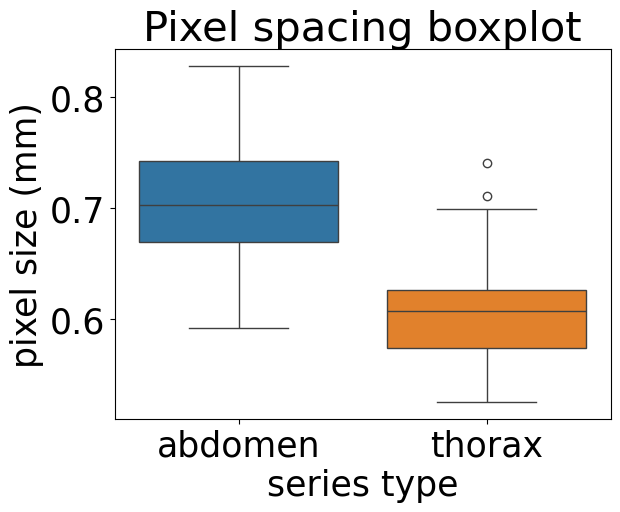

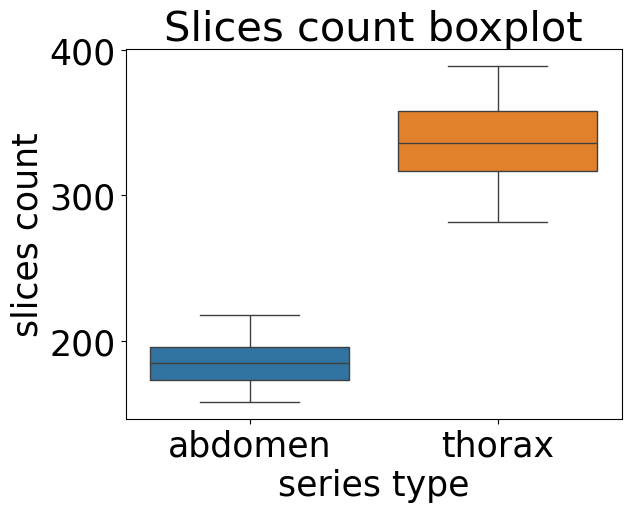

In [28]:
# Resolution information
print("pixel size stats")
print(30 * "-")
display(series_df['row_spacing_mm'].describe())
display(series_df.groupby('series_region')['row_spacing_mm'].describe())
print("slices count stats")
print(30 * "-")
display(series_df['slices'].describe())
display(series_df.groupby('series_region')['slices'].describe())
# Plot pixel spacing
sns.boxplot(
    data=series_df,
    x='series_region',
    y='row_spacing_mm',
    hue='series_region',
    legend=False
)
plt.title('Pixel spacing boxplot')
plt.xlabel('series type')
plt.ylabel('pixel size (mm)')
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'pixel_spacing_grouped.svg', bbox_inches='tight', transparent=True)
plt.show()
# Plot slices count
sns.boxplot(
    data=series_df,
    x='series_region',
    y='slices',
    hue='series_region',
    legend=False
)
plt.title('Slices count boxplot')
plt.xlabel('series type')
plt.ylabel('slices count')
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'slices_count_grouped.svg', bbox_inches='tight', transparent=True)
plt.show()

In [29]:
plt.rcParams.update({'font.size': 16}) # 25 for histograms and boxplots, 16 for bars

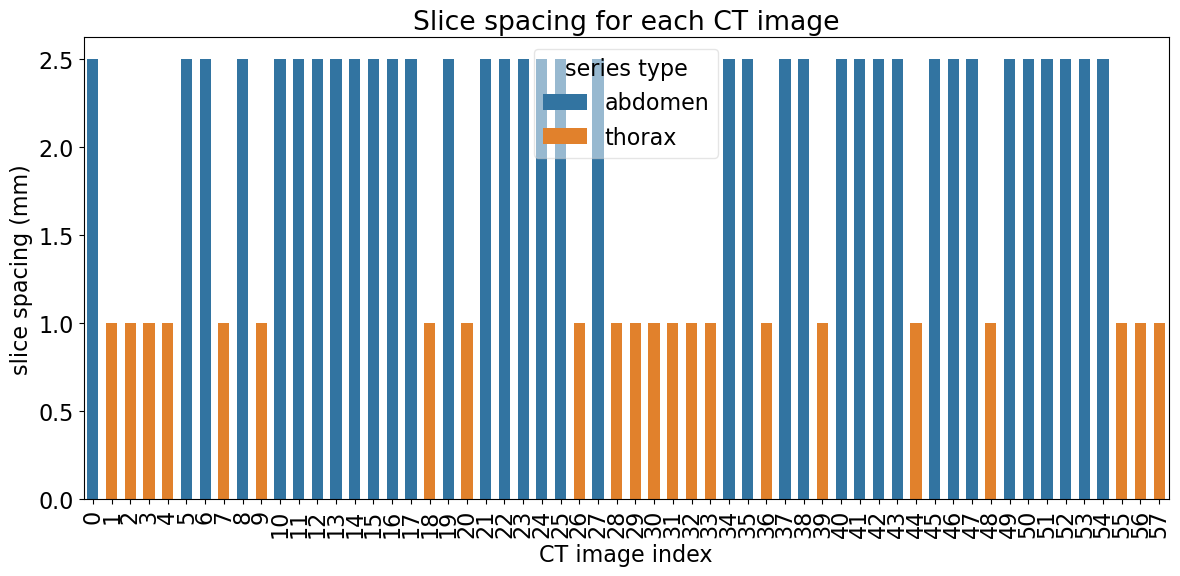

In [30]:
# Plot Slice Thickness
plt.figure(figsize=(14,6))
sns.barplot(data=series_df, x=series_df.index, y='slice_spacing_mm', hue='series_region', dodge=False, width=0.6)
plt.xticks(rotation=90)
plt.legend(title='series type', framealpha=0.5)
plt.xlabel('CT image index')
plt.ylabel('slice spacing (mm)')
plt.title('Slice spacing for each CT image')
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'slice_spacing_grouped.svg', bbox_inches='tight', transparent=True)
plt.show()

In [31]:
# Image intensity stats
stats_df = pd.DataFrame()
for subset, path in [('train', path_to_image_stats_train), ('test', path_to_image_stats_test)]:
    df = pd.read_csv(path)
    df['subset'] = subset
    stats_df = pd.concat([stats_df, df], ignore_index=True)
stats_df['uuid'] = stats_df["filename"].apply(lambda x: x.split('.nii.gz')[0])
stats_df = stats_df.merge(
    series_df[['uuid', 'series_region']],
    on='uuid',
    how='left'
)
display(stats_df.groupby('series_region').describe())

slices                                                     \
               count        mean        std    min    25%    50%    75%   
series_region                                                             
abdomen         36.0  185.111111  16.166593  158.0  173.0  184.5  196.0   
thorax          22.0  337.272727  30.089045  282.0  317.0  336.0  358.0   

                      rows                                                 \
                 max count   mean  std    min    25%    50%    75%    max   
series_region                                                               
abdomen        218.0  36.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0   
thorax         389.0  22.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0   

              columns                                                 mean  \
                count   mean  std    min    25%    50%    75%    max count   
series_region                                                                
abdomen          36.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0  36.0   
thorax           22.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0  22.0   

                                                                        \
                     mean        std       min         25%         50%   
series_region                                                            
abdomen       -516.070892  45.045419 -588.1511 -543.985600 -522.287220   
thorax        -432.606601  62.181781 -569.5046 -471.316055 -428.395165   

                                       std                                    \
                      75%        max count        mean        std        min   
series_region                                                                  
abdomen       -478.416285 -403.27360  36.0  498.043641   6.940746  480.73492   
thorax        -396.516917 -316.18167  22.0  503.362983  21.221844  457.44028   

                                                              min          \
                      25%         50%         75%       max count    mean   
series_region                                                               
abdomen        493.968853  498.559145  501.362435  512.8142  36.0 -1024.0   
thorax         490.627485  504.874080  515.194300  537.7687  22.0 -1024.0   

                                                              Q1              \
               std     min     25%     50%     75%     max count        mean   
series_region                                                                  
abdomen        0.0 -1024.0 -1024.0 -1024.0 -1024.0 -1024.0  36.0 -994.944444   
thorax         0.0 -1024.0 -1024.0 -1024.0 -1024.0 -1024.0  22.0 -936.545455   

                                                                 Q2  \
                     std     min    25%    50%     75%    max count   
series_region                                                         
abdomen         3.277145 -1001.0 -997.0 -996.0 -993.00 -987.0  36.0   
thorax         24.110316  -975.0 -949.0 -940.5 -929.75 -866.0  22.0   

                                                                           \
                     mean         std    min    25%    50%     75%    max   
series_region                                                               
abdomen       -727.250000  284.317265 -942.0 -914.0 -889.0 -586.75 -113.0   
thorax        -427.227273  288.026608 -894.0 -740.5 -277.0 -196.25 -132.0   

                 Q3                                                       \
              count      mean        std   min    25%   50%    75%   max   
series_region                                                              
abdomen        36.0 -7.666667  26.667262 -79.0 -18.75  -4.5  10.75  26.0   
thorax         22.0  8.954545  18.135672 -27.0  -5.50  10.0  22.75  47.0   

                max                                                    \
              count         mean         std     min      25%     50%   
series_region                    

In [32]:
plt.rcParams.update({'font.size': 25}) # 25 for histograms and boxplots, 16 for bars

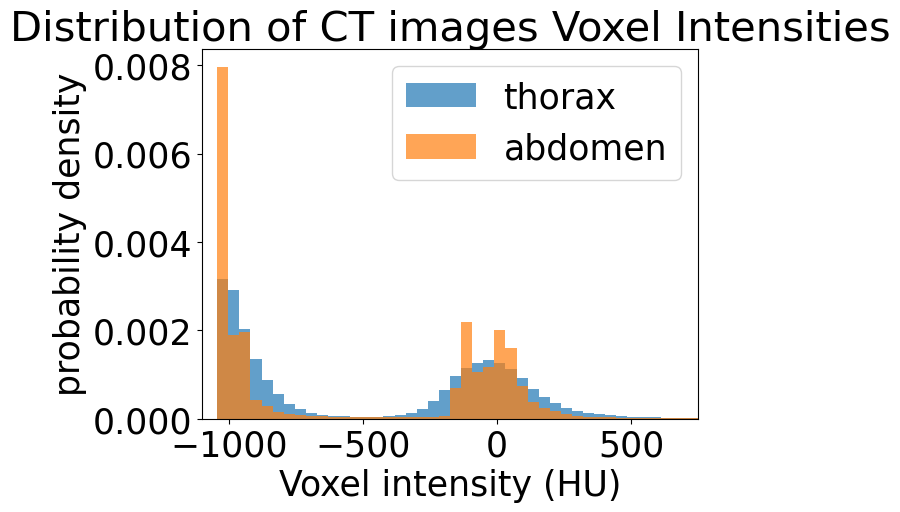

In [33]:
# Distribution (density) of images intensities
densities = {}
for path in [path_to_image_densities_train, path_to_image_densities_test]:
    densities.update(np.load(path, allow_pickle=True).item())
grouped_densities = {"thorax": [], "abdomen": []}
series_df.set_index('uuid', inplace=True)
for fname, value in densities.items():
    uuid = fname.split('.nii.gz')[0]
    region = series_df.loc[uuid, 'series_region']
    grouped_densities[region].append({"filename": fname, **value})
series_df.reset_index(inplace=True)
mean_densities = {
    region: {
        "density": np.mean(np.concatenate([subitem["density"].reshape(-1,1) for subitem in item], axis=1), axis=1),
        "bins": item[-1]["bins"]
    }
    for region, item in grouped_densities.items()
}
# Plot
for region in mean_densities.keys():
    area = np.sum(mean_densities[region]["density"] * np.diff(mean_densities[region]["bins"]))
    plt.bar(
        mean_densities[region]["bins"][:-1],
        mean_densities[region]["density"] / area,
        width=np.diff(mean_densities[region]["bins"]),
        alpha=0.7,
        label=region
    )
plt.xlabel('Voxel intensity (HU)')
plt.ylabel('probability density')
plt.title('Distribution of CT images Voxel Intensities')
plt.xlim((-1100, 750))
plt.legend()
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'voxel_intensities_distribution.svg', bbox_inches='tight', transparent=True)
plt.show()